# Getting started with SimBo
SimBio is a Python-based package for simulation of Chemical Reaction Networks (CRNs). It extends [poincare](https://dyscolab.github.io/poincare/), a package for modelling dynamical systems, to add functionality for CRNs.



### Installation

Using [pixi](https://pixi.sh/latest/),
install from PyPI with:

```sh
pixi add --pypi simbio
```

or install the latest development version from GitHub with:

```sh
pixi add --pypi simbio@https://github.com/dyscolab/simbio.git
```

Otherwise,
use `pip` or your `pip`-compatible package manager:

```sh
pip install simbio  # from PyPI
pip install git+https://github.com/dyscolab/simbio.git  # from GitHub
```

To install poincaré from a Jupyter notebook / Google Colab,
run the following command on a cell:
```
!uv pip install poincare
```

### Creating and simulating a Model
To create a model we must create class which inherits from `Compartment`, which can contain a certain amount of different `Species`, in this case, A, B and C. We can define a `RateLaw` to add the reaction 2A + B $\rightarrow$ C.


In [1]:
from simbio import Compartment, RateLaw, Species, initial


class Model(Compartment):
    # Create species A, B, and C, each with intial value 1
    A: Species = initial(default=1)
    B: Species = initial(default=1)
    C: Species = initial(default=1)

    reaction = RateLaw(reactants=[2 * A, B], products=[C], rate_law=1)

Would be equivalent to the equations:
$$
\begin{aligned}
\frac{dA}{dt} &= -2 \\
\frac{dB}{dt} &= -1 \\
\frac{dC}{dt} &= 1 
\end{aligned}
$$

To simulate it we must create a `Simulator` for it

<Axes: xlabel='time'>

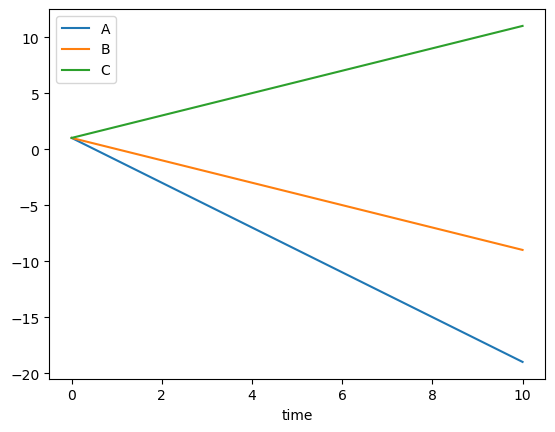

In [ ]:
import numpy as np

from simbio import Simulator

sim = Simulator(Model)
result = sim.solve(save_at=np.linspace(0, 10, 100))
result.plot()

`Simulator.solve` outputs a [pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), and can be plotted with the `plot()` method. See Poincare's documentation (__agragar link cuando lo subamos__) for mor information on solvers.

We can vary initial conditions by passing a `values` dictionary to the `solve()`

In [3]:
sim.solve(save_at=range(3), values={Model.A: 2, Model.B: 0.5})

,A,B,C
time,,,
0,2.0,0.5,1.0
1,0.0,-0.5,2.0
2,-2.0,-1.5,3.0


### Mass action reactions
In the previous example the reaction happened at a constant rate. We can also implement it as a Mass action reaction

In [4]:
from simbio import MassAction


class ModelMA(Compartment):
    # Create species A, B, and C, each with intial value 1
    A: Species = initial(default=1)
    B: Species = initial(default=1)
    C: Species = initial(default=1)

    reaction = MassAction(reactants=[2 * A, B], products=[C], rate=1)

Corresponds to the equations:
$$
\begin{aligned}
\frac{dA}{dt} &= -2A^2 \\
\frac{dB}{dt} &= -B\\
\frac{dC}{dt} &= A^2B 
\end{aligned}
$$

<Axes: xlabel='time'>

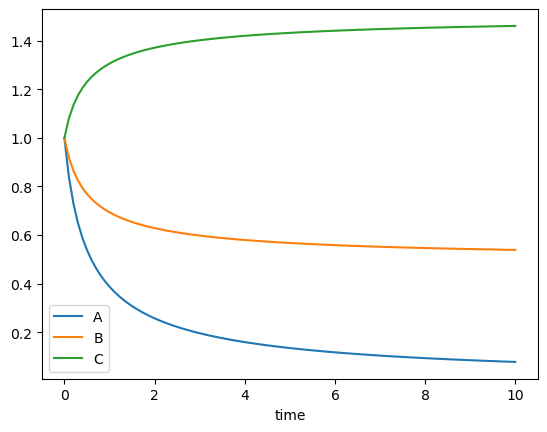

In [5]:
simMA = Simulator(ModelMA)
result = simMA.solve(save_at=np.linspace(0, 10, 100))
result.plot()

### Constants and Parameters

Besides variables,
we can define parameters and constants,

#### Constants

Constants allow to define common initial conditions for Variables:

In [6]:
from simbio import Constant, assign


class ModelConst(Compartment):
    # Create a constant c to set intial conditions for A and B
    c: Constant = assign(default=1, constant=True)

    # Create species A, B, and C, each with intial value 1
    A: Species = initial(default=c)
    B: Species = initial(default=2 * c)
    C: Species = initial(default=1)

    reaction = RateLaw(reactants=[2 * A, B], products=[C], rate_law=1)


Simulator(ModelConst).solve(save_at=range(3))

,A,B,C
time,,,
0,1.0,2.0,1.0
1,-1.0,1.0,2.0
2,-3.0,0.0,3.0


Now, we can vary their initial conditions jointly:


In [7]:
Simulator(ModelConst).solve(values={ModelConst.c: 2}, save_at=range(3))

,A,B,C
time,,,
0,2.0,4.0,1.0
1,0.0,3.0,2.0
2,-2.0,2.0,3.0


But we can break that connection by passing `y`'s initial value directly:


In [8]:
Simulator(ModelConst).solve(values={ModelConst.c: 2, ModelConst.B: 3}, save_at=range(3))

,A,B,C
time,,,
0,2.0,3.0,1.0
1,0.0,2.0,2.0
2,-2.0,1.0,3.0


#### Parameters


Parameters are like Variables,
but their time evolution is given directly as a function of time,
Variables, Constants and other Parameters. Their default value can also be changed in `values`:

In [9]:
from simbio import Parameter


class ModelParametrized(Compartment):
    # Create species A, B, and C, each with intial value 1
    A: Species = initial(default=1)
    B: Species = initial(default=1)
    C: Species = initial(default=1)

    # Create a rate parameter to control the rate
    rate: Parameter = assign(default=1)

    reaction = RateLaw(reactants=[2 * A, B], products=[C], rate_law=rate)


Simulator(ModelParametrized).solve(save_at=range(3), values={ModelParametrized.rate: 3})

,A,B,C
time,,,
0,1.0,1.0,1.0
1,-5.0,-2.0,4.0
2,-11.0,-5.0,7.0


### Other utilities
SimBio contains a number of built in classes to represent common reactions, which can be found in `simbio.reactions.single`:
- `Creation(A: Species, rate: Parameter)`: A substance `A` is created from nothing at a given rate, ∅ -> A.
- `AutoCreation(A: Species, rate: Parameter)`: A substance `A` is created at a rate proportional to its abundance, A -> 2A.
- `Destruction(A: Species, rate: Parameter)`: A substance `A` degrades into nothing, A -> ∅.
- `Conversion(A: Species, B: Species, rate: Parameter)`: A substance `A` converts into `B`, A -> B.
- `Synthesis(A: Species, B: Species, AB: Species, rate: Parameter)`:  Two simple substances `A` and `B` combine to form a more complex substance `AB`, A + B -> AB.
- `Dissociation(AB: Species, A: Species, B: Species, rate: Parameter)`: A more complex substance `AB` breaks down into its more simple parts `A` and `B`, AB -> A + B.

Except for `Creation`, where the reaction always occurs at a given rate, all rates are set according to `MassAction` rules, so `Synthesis(A = 2*A, B=B, AB = AB, rate=k)` would represent:
$$
\begin{aligned}
\frac{dA}{dt}&=- 2 A^{2} B k\\
\frac{dB}{dt}&= -A^{2} B k\\
\frac{dAB}{dt}&= A^{2} B k\\
\end{aligned}
$$

There are also built in two-way reactions in `simbio.reactions.compound`:
- `ReversibleSynthesis(A: Species, B: Species, AB: Species, forward_rate: Parameter, reverse_rate: Parameter)`: A `Synthesis` and `Dissociation` reactions each with a separate `rate`, A + B <-> AB. 
- `Equilibration(A: Species, B: Species, forward_rate: Parameter, reverse_rate: Parameter)`: A forward and backward `Conversion`, each with a separate `rate`, A <-> B.
- `CatalyzeConvert(A: Species, B: Species, AB: Species, P: Species, forward_rate: Parameter, reverse_rate: Parameter, conversion_rate: Parameter)`: A `ReversibleSynthesis` between `A`, `B`, and `AB`, and a `Conversion` from `AB` to `P` with `rate = conversion_rate`, A + B <-> A:B -> P.
 




For more details into SimBio's capabilities, we recommend reading [poincare's documentation](https://dyscolab.github.io/poincare/).

$$